In [279]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import joblib

In [280]:
all_tracking_tackles_play_defense = pd.read_csv("all_tracking_tackles_play_defense.csv")

In [281]:
all_tracking_tackles_play_defense['blocker_influence'].min()

np.float64(0.0001734387433716)

In [282]:
all_tracking_tackles_play_defense['blocker_influence'].max()

np.float64(8.116464953967713)

In [283]:
print(len(all_tracking_tackles_play_defense))

5828669


In [284]:
all_tracking_tackles_play_defense.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'gameId', 'playId', 'frameId', 'nflId',
       'displayName_x', 'x', 'y', 's', 'a', 'o', 'dir', 'ballCarrierId',
       'height', 'weight', 'ballCarrierDisplayName', 'ball_carrier_x',
       'ball_carrier_y', 'ball_carrier_speed', 'ball_carrier_acceleration',
       'ball_carrier_dir', 'ball_carrier_orientation', 'ball_carrier_height',
       'ball_carrier_weight', 'distance_to_ball_carrier', 'is_offense',
       'is_defense', 'tackle', 'assist', 'pff_missedTackle', 'event',
       'position', 'defender_influence', 'blocker_influence', 'weight_diff',
       'height_diff'],
      dtype='object')

In [285]:
all_tracking_tackles_play_defense['play_made'] = (
    (all_tracking_tackles_play_defense['tackle'] == 1) |
    (all_tracking_tackles_play_defense['assist'] == 1)
).astype(int)

all_tracking_tackles_play_defense['speed_diff'] = all_tracking_tackles_play_defense['s'] - all_tracking_tackles_play_defense['ball_carrier_speed']
all_tracking_tackles_play_defense['acc_diff'] = all_tracking_tackles_play_defense['a'] - all_tracking_tackles_play_defense['ball_carrier_acceleration']


In [286]:
keep_all = all_tracking_tackles_play_defense

In [287]:
all_tracking_tackles_play_defense['play_made'].value_counts()

play_made
0    5142091
1     686578
Name: count, dtype: int64

In [288]:
def filter_after_handoff(df, event_column='handoff'):
    """
    Filters the dataset to only include frames occurring after the handoff.

    Args:
    df (pd.DataFrame): The tracking dataset containing frame data.
    event_column (str): The column indicating handoff event (1 if handoff occurred, 0 otherwise).

    Returns:
    pd.DataFrame: Filtered data containing only frames after the handoff.
    """
    filtered_data = []

    for _, group in df.groupby(['gameId', 'playId']):
        handoff_frames = group[group['event'] == "handoff"]['frameId']

        if not handoff_frames.empty:
            handoff_frame = handoff_frames.min()  # First frame when the handoff occurs
            after_handoff = group[group['frameId'] >= handoff_frame]  # Keep frames at or after handoff
            filtered_data.append(after_handoff)

    return pd.concat(filtered_data, ignore_index=True)




In [289]:
def filter_after_catch(df, event_column='pass_outcome_caught'):
    """
    Filters the dataset to only include frames occurring after the catch.

    Args:
    df (pd.DataFrame): The tracking dataset containing frame data.
    event_column (str): The column indicating catch event (1 if catch occurred, 0 otherwise).

    Returns:
    pd.DataFrame: Filtered data containing only frames after the catch.
    """
    filtered_data = []

    for _, group in df.groupby(['gameId', 'playId']):
        catch_frames = group[group['event'] == "pass_outcome_caught"]['frameId']

        if not catch_frames.empty:
            catch_frame = catch_frames.min()  # First frame when the catch occurs
            after_catch = group[group['frameId'] >= catch_frame]  # Keep frames at or after catch
            filtered_data.append(after_catch)

    return pd.concat(filtered_data, ignore_index=True)




In [290]:
df_after_catch = filter_after_catch(all_tracking_tackles_play_defense)
df_after_handoff = filter_after_handoff(all_tracking_tackles_play_defense)

In [291]:
features = ['s', 'a', 'o', 'dir',
       'ball_carrier_speed',
       'ball_carrier_acceleration',
       'ball_carrier_dir', 'ball_carrier_orientation',
       'ball_carrier_weight', 'distance_to_ball_carrier',
       'defender_influence']

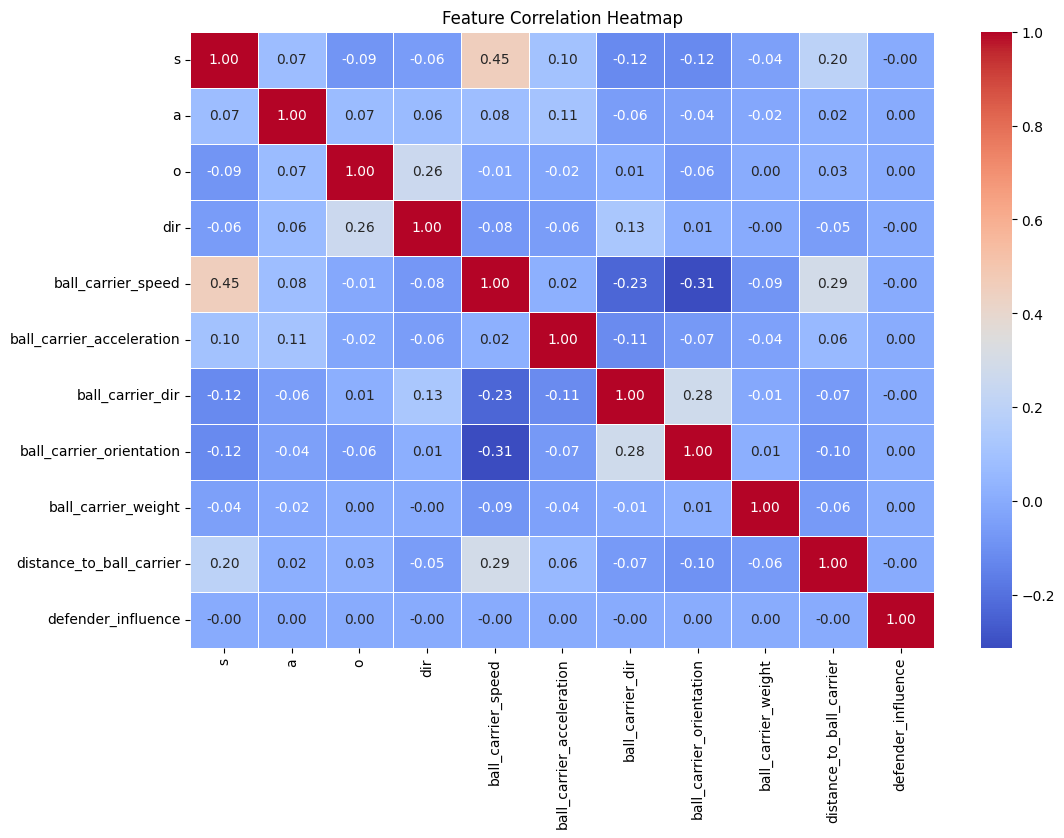

In [292]:
# Compute correlation matrix
correlation_matrix = df_after_handoff[features].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


In [293]:
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.model_selection import train_test_split


def split_data(data, features):
  X = data[features]
  y = data['play_made']

  # Train (70%), Validation (15%), Test (15%) split
  X_train, X_temp, y_train, y_temp = train_test_split(
      X, y, test_size=0.3, random_state=42, stratify=y
  )
  X_val, X_test, y_val, y_test = train_test_split(
      X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
  )

  return X_train, X_val, X_test, y_train, y_val, y_test



def make_model(X_train, y_train, X_val, y_val):
  # Create pipeline
  estimators = [
    ('clf', XGBClassifier(random_state=8))
  ]
  clf = XGBClassifier(random_state=8)


  # Set up hyperparameter tuning
  search_space = {
    'max_depth': Integer(3, 10),
    'learning_rate': Real(0.001, 1.0, 'log-uniform'),
    'subsample': Real(0.5, 1.0, 'uniform'),
    'colsample_bytree': Real(0.5, 1.0, 'uniform'),
    'colsample_bylevel': Real(0.5, 1.0, 'uniform'),
    'colsample_bynode': Real(0.5, 1.0, 'uniform'),
    'gamma': Real(0.0, 0.5, 'uniform'),
    'reg_alpha': Real(0.0, 1.0, 'uniform'),
    'reg_lambda': Real(0.0, 1.0, 'uniform'),
    'max_delta_step': Integer(0, 10),
}


  opt = BayesSearchCV(
    clf, search_space, n_iter=32, cv=5, n_jobs=-1, random_state=8, scoring='roc_auc'
  )

  opt.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

  return opt


In [294]:
# Splitting data uniquely for each dataset
X_train_handoff, X_val_handoff, X_test_handoff, y_train_handoff, y_val_handoff, y_test_handoff = split_data(df_after_handoff, features)
after_handoff_model = make_model(X_train_handoff, y_train_handoff, X_val_handoff, y_val_handoff)

X_train_catch, X_val_catch, X_test_catch, y_train_catch, y_val_catch, y_test_catch = split_data(df_after_catch, features)
after_catch_model = make_model(X_train_catch, y_train_catch, X_val_catch, y_val_catch)

X_train_all, X_val_all, X_test_all, y_train_all, y_val_all, y_test_all = split_data(all_tracking_tackles_play_defense, features)
after_all_model = make_model(X_train_all, y_train_all, X_val_all, y_val_all)

import joblib

# Save models
joblib.dump(after_handoff_model, "after_handoff_model.pkl")
joblib.dump(after_catch_model, "after_catch_model.pkl")
joblib.dump(after_all_model, "after_all_model.pkl")



[0]	validation_0-logloss:0.39141
[0]	validation_0-logloss:0.39141
[0]	validation_0-logloss:0.39141
[0]	validation_0-logloss:0.39141
[1]	validation_0-logloss:0.39127
[1]	validation_0-logloss:0.39129
[1]	validation_0-logloss:0.39127
[1]	validation_0-logloss:0.39138
[2]	validation_0-logloss:0.39109
[2]	validation_0-logloss:0.39110
[2]	validation_0-logloss:0.39123
[2]	validation_0-logloss:0.39109
[3]	validation_0-logloss:0.39096
[3]	validation_0-logloss:0.39105
[3]	validation_0-logloss:0.39107
[3]	validation_0-logloss:0.39106
[4]	validation_0-logloss:0.39093
[4]	validation_0-logloss:0.39087
[4]	validation_0-logloss:0.39092
[4]	validation_0-logloss:0.39091
[5]	validation_0-logloss:0.39090
[0]	validation_0-logloss:0.39141
[5]	validation_0-logloss:0.39074
[5]	validation_0-logloss:0.39072
[5]	validation_0-logloss:0.39089
[6]	validation_0-logloss:0.39086
[6]	validation_0-logloss:0.39062
[1]	validation_0-logloss:0.39127
[6]	validation_0-logloss:0.39076
[6]	validation_0-logloss:0.39069
[7]	valida

['after_all_model.pkl']

In [295]:
# Load models later
# after_handoff_model = joblib.load("after_handoff_model.pkl")
# after_catch_model = joblib.load("after_catch_model.pkl")
# after_all_model = joblib.load("after_all_model.pkl")

handoff


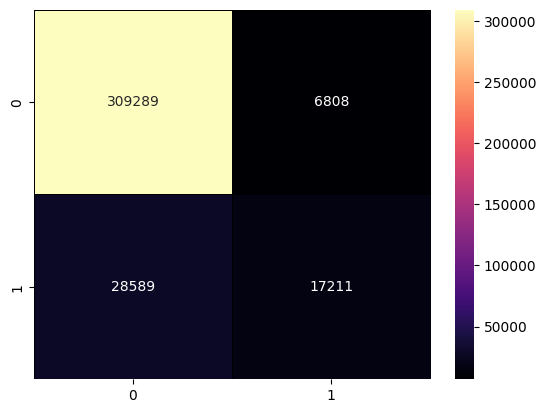

all


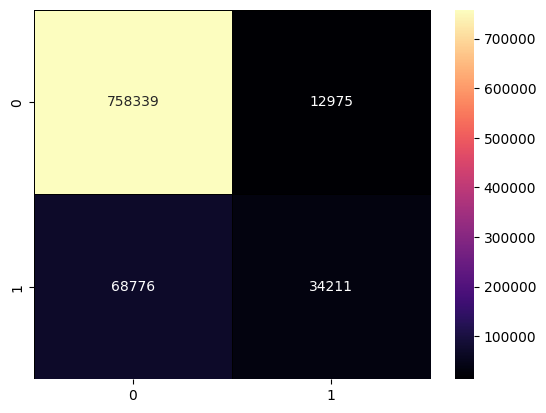

catch


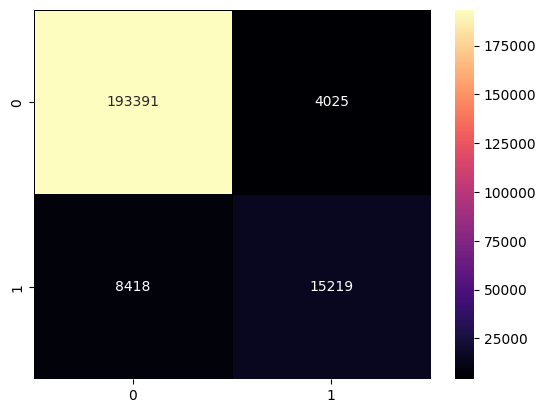

In [296]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Define models and datasets
models_data = {
    "handoff": (after_handoff_model, X_test_handoff, y_test_handoff),
    "all": (after_all_model, X_test_all, y_test_all),
    "catch": (after_catch_model, X_test_catch, y_test_catch)
}

# Define scoring metrics and corresponding functions
metrics = {
    "accuracy": accuracy_score,
    "precision": lambda y_true, y_pred: precision_score(y_true, y_pred, average=None, zero_division=0),
    "recall": lambda y_true, y_pred: recall_score(y_true, y_pred, average=None, zero_division=0),
    "f1": lambda y_true, y_pred: f1_score(y_true, y_pred, average=None, zero_division=0)
}

# Store results
results = {}

# Loop through models and datasets
for name, (model, train, test) in models_data.items():
    best_threshold = 0.5
    best_f1 = 0
    y_prob = model.predict_proba(train)[:, 1]

    y_pred_adjusted = (y_prob >=  best_threshold).astype(int)
    cm = confusion_matrix(test, y_pred_adjusted)
    sns.heatmap(cm, annot=True, fmt="d", cmap="magma", linewidths=0.5, linecolor='black')


    print(name)
    plt.show()


    # Compute metrics for each class
    results[name] = {}
    for metric_name, metric_func in metrics.items():
        values = metric_func(test, y_pred_adjusted)
        results[name]['best_threshold'] = best_threshold
        if metric_name == "accuracy":
            results[name]["accuracy"] = values  # Accuracy is not per class
        else:
            results[name][f"{metric_name}_class_0"] = values[0]  # Negative class (no play made)
            results[name][f"{metric_name}_class_1"] = values[1]  # Positive class (play made)

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame.from_dict(results, orient='index')



In [297]:
results_df

,best_threshold,accuracy,precision_class_0,precision_class_1,recall_class_0,recall_class_1,f1_class_0,f1_class_1
handoff,0.5,0.902190,0.915387,0.716558,0.978462,0.375786,0.945874,0.493018
all,0.5,0.906496,0.916848,0.725024,0.983178,0.332188,0.948855,0.455621
catch,0.5,0.943710,0.958287,0.790844,0.979612,0.643863,0.968832,0.709825


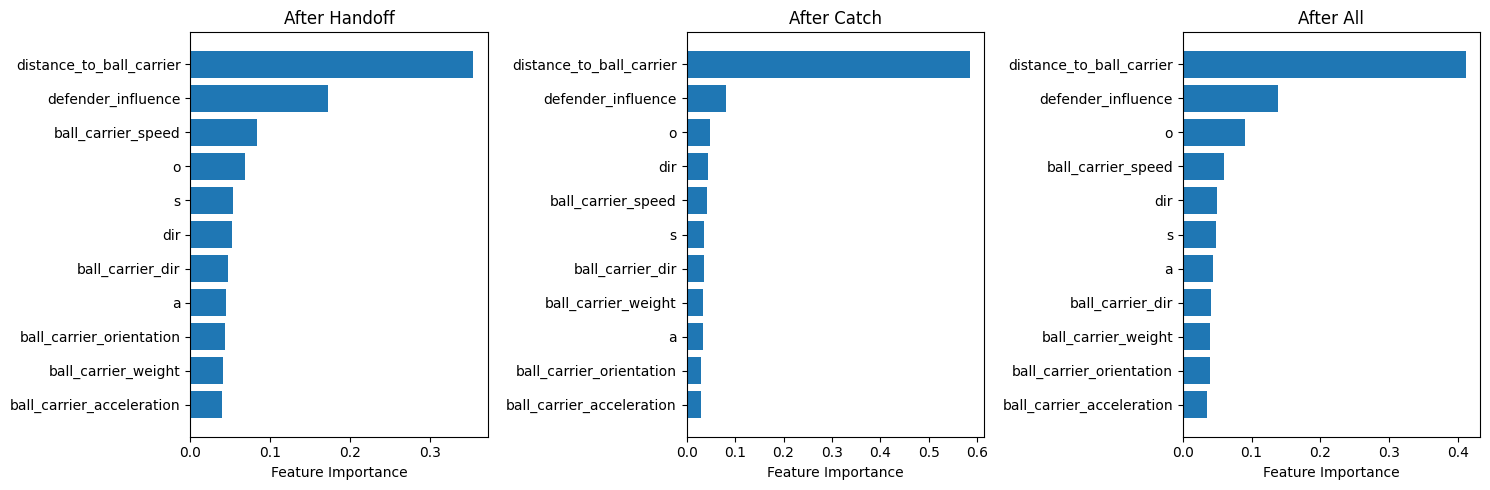

In [320]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Extract XGBoost models from pipelines
xgboost_models = {
    "After Handoff": after_handoff_model.best_estimator_,
    "After Catch": after_catch_model.best_estimator_,
    "After All": after_all_model.best_estimator_,
}

import pandas as pd
import matplotlib.pyplot as plt

# Extract feature importance
def plot_feature_importance(model, feature_names, title, ax):
    importances = model.feature_importances_
    sorted_idx = importances.argsort()

    ax.barh([feature_names[i] for i in sorted_idx], importances[sorted_idx])
    ax.set_title(title)
    ax.set_xlabel("Feature Importance")

# Feature names (assuming all models use the same features)
feature_names = after_handoff_model.best_estimator_.feature_names_in_

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot for each model
for ax, (title, model) in zip(axes, xgboost_models.items()):
    plot_feature_importance(model, feature_names, title, ax)

plt.tight_layout()
plt.show()

#Feature importanc

In [321]:
keep_all

,Unnamed: 0.1,Unnamed: 0,gameId,playId,frameId,nflId,displayName_x,x,y,s,...,position,defender_influence,blocker_influence,weight_diff,height_diff,play_made,speed_diff,acc_diff,prediction,probability
0,22,22,2022090800,56,1,38577.0,Bobby Wagner,41.75,25.77,1.24,...,ILB,0.112588,1.254574,51,0,0,-4.99,2.91,0,0.011778
1,23,23,2022090800,56,2,38577.0,Bobby Wagner,41.80,25.61,1.78,...,ILB,0.173711,1.260834,51,0,0,-4.46,3.16,0,0.195966
2,24,24,2022090800,56,3,38577.0,Bobby Wagner,41.84,25.42,2.21,...,ILB,0.233504,1.270333,51,0,0,-3.77,1.72,0,0.057269
3,25,25,2022090800,56,4,38577.0,Bobby Wagner,41.86,25.17,2.70,...,ILB,0.312264,1.284189,51,0,0,-2.97,0.50,0,0.012688
4,26,26,2022090800,56,5,38577.0,Bobby Wagner,41.88,24.88,3.05,...,ILB,0.390421,1.289473,51,0,0,-2.38,-0.46,0,0.016489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5828664,11657289,11657289,2022110700,3787,40,54606.0,Damarion Williams,33.45,29.73,1.92,...,CB,0.155638,1.338559,-43,-4,0,0.32,-1.64,0,0.007553
5828665,11657290,11657290,2022110700,3787,41,54606.0,Damarion Williams,33.42,29.57,1.53,...,CB,0.125623,1.403811,-43,-4,0,0.49,-1.59,0,0.003099
5828666,11657291,11657291,2022110700,3787,42,54606.0,Damarion Williams,33.39,29.43,1.28,...,CB,0.106263,1.467758,-43,-4,0,0.74,-1.62,0,0.003019
5828667,11657292,11657292,2022110700,3787,43,54606.0,Damarion Williams,33.38,29.31,1.07,...,CB,0.089442,1.525725,-43,-4,0,0.82,-1.41,0,0.008609


In [322]:
keep_all['prediction'] = after_catch_model.predict(keep_all[features])
keep_all['probability'] = after_catch_model.predict_proba(keep_all[features])[:, 1]


In [323]:
keep_all[keep_all['prediction'] == 0]['probability'].mean()

np.float32(0.056025602)

In [324]:
keep_all[keep_all['prediction'] == 1]['probability'].mean()

np.float32(0.7556632)

In [325]:
game_id = 2022110700  # Replace with the actual game ID
play_id = 2902  # Replace with the actual play ID

play_data = keep_all[
    (keep_all['gameId'] == game_id) &
    (keep_all['playId'] == play_id)
]

play_data['ballCarrierDisplayName']

5813852    Kenyan Drake
5813853    Kenyan Drake
5813854    Kenyan Drake
5813855    Kenyan Drake
5813856    Kenyan Drake
               ...     
5814815    Kenyan Drake
5814816    Kenyan Drake
5814817    Kenyan Drake
5814818    Kenyan Drake
5814819    Kenyan Drake
Name: ballCarrierDisplayName, Length: 968, dtype: object

[84]


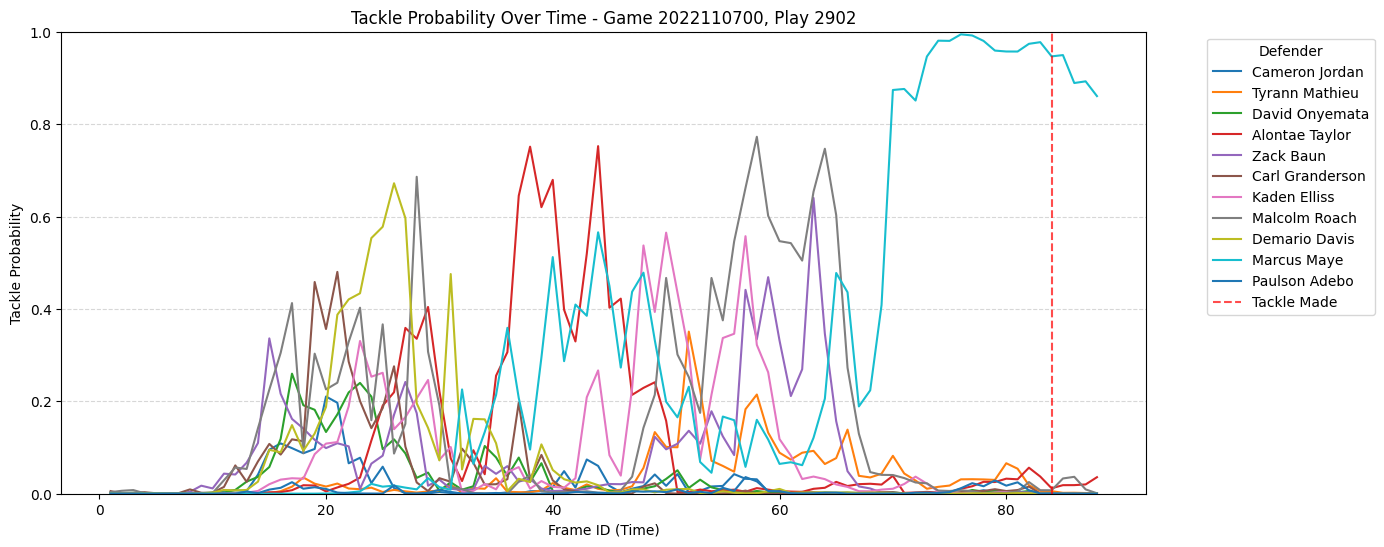

In [326]:
import matplotlib.pyplot as plt
import seaborn as sns



# Sort by frameId for proper time progression
play_data = play_data.sort_values(by='frameId')

# Get the frame where the tackle was made (if any)
tackle_frames = play_data[(play_data['event'] == 'tackle') | (play_data['event'] == 'assist')]['frameId'].unique()
print(tackle_frames)

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=play_data,
    x='frameId',
    y='probability',
    hue='displayName_x',
    palette='tab10'
)

# Draw vertical lines for frames where a tackle was made
for frame in tackle_frames:
    plt.axvline(x=frame, color='red', linestyle='--', alpha=0.7, label='Tackle Made' if frame == tackle_frames[0] else "")


# Labels and title
plt.xlabel('Frame ID (Time)')
plt.ylabel('Tackle Probability')
plt.title(f'Tackle Probability Over Time - Game {game_id}, Play {play_id}')
plt.legend(title="Defender", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.ylim(0, 1)


# Show the plot
plt.show()


In [327]:
keep_all['prediction'] = (keep_all['probability'] > 0.75).astype(int)
predicted_tackles = keep_all.groupby(['playId', 'frameId', 'displayName_x', 'gameId', 'position'])['probability'].sum()
actual_tackles = keep_all.groupby(['playId', 'frameId', 'displayName_x', 'gameId', 'position'])['play_made'].sum()



In [328]:
predicted_tackles.reset_index()

,playId,frameId,displayName_x,gameId,position,probability
0,54,1,Adrian Amos,2022092512,FS,0.031303
1,54,1,Benjamin St-Juste,2022101300,CB,0.000206
2,54,1,Bobby McCain,2022101300,FS,0.000004
3,54,1,Bradley Roby,2022100200,CB,0.003642
4,54,1,Cameron Jordan,2022100200,DE,0.000500
...,...,...,...,...,...,...
5828664,5096,26,Logan Wilson,2022091103,ILB,0.000074
5828665,5096,26,Mike Hilton,2022091103,CB,0.090872
5828666,5096,26,Sam Hubbard,2022091103,DE,0.040326
5828667,5096,26,Trey Hendrickson,2022091103,DE,0.000005


In [329]:
actual_tackles.reset_index()

,playId,frameId,displayName_x,gameId,position,play_made
0,54,1,Adrian Amos,2022092512,FS,0
1,54,1,Benjamin St-Juste,2022101300,CB,0
2,54,1,Bobby McCain,2022101300,FS,0
3,54,1,Bradley Roby,2022100200,CB,0
4,54,1,Cameron Jordan,2022100200,DE,0
...,...,...,...,...,...,...
5828664,5096,26,Logan Wilson,2022091103,ILB,0
5828665,5096,26,Mike Hilton,2022091103,CB,0
5828666,5096,26,Sam Hubbard,2022091103,DE,0
5828667,5096,26,Trey Hendrickson,2022091103,DE,0


In [330]:
combined = pd.merge(predicted_tackles, actual_tackles, on = ['displayName_x', 'playId', 'frameId', 'gameId', 'position']).reset_index()
combined

,displayName_x,playId,frameId,gameId,position,probability,play_made
0,Adrian Amos,54,1,2022092512,FS,0.031303,0
1,Benjamin St-Juste,54,1,2022101300,CB,0.000206,0
2,Bobby McCain,54,1,2022101300,FS,0.000004,0
3,Bradley Roby,54,1,2022100200,CB,0.003642,0
4,Cameron Jordan,54,1,2022100200,DE,0.000500,0
...,...,...,...,...,...,...,...
5828664,Logan Wilson,5096,26,2022091103,ILB,0.000074,0
5828665,Mike Hilton,5096,26,2022091103,CB,0.090872,0
5828666,Sam Hubbard,5096,26,2022091103,DE,0.040326,0
5828667,Trey Hendrickson,5096,26,2022091103,DE,0.000005,0


In [331]:
combined['TOE'] = combined['play_made'] - combined['probability']

In [332]:
TOE_ranking = combined.groupby(['displayName_x', 'position'])['TOE'].sum().reset_index().sort_values('TOE', ascending=False).head(50)


In [333]:
TOE_ranking['position'].value_counts()

position
ILB    21
SS     10
FS      7
OLB     6
CB      4
DE      2
Name: count, dtype: int64

In [338]:
linebacker_toe = TOE_ranking[TOE_ranking['position'].isin(['ILB', 'OLB'])].sort_values('TOE', ascending=False)
secondary_toe = TOE_ranking[TOE_ranking['position'].isin(['FS', 'SS', 'CB'])].sort_values('TOE', ascending=False)



In [341]:
secondary_toe

,displayName_x,position,TOE
444,Jonathan Owens,FS,1467.640691
111,Budda Baker,SS,1047.689864
404,Jeff Okudah,CB,835.453279
234,DeShon Elliott,FS,826.143715
263,Derwin James,FS,800.699015
290,Eddie Jackson,SS,627.190549
192,Damar Hamlin,SS,610.509032
267,Devin McCourty,FS,609.203912
498,Kareem Jackson,SS,583.772614
172,Chuck Clark,SS,580.617310


In [314]:
len(actual_tackles)

5828669

In [315]:
len(predicted_tackles)

5828669

In [316]:
predicted_tackles

playId  frameId  displayName_x      gameId      position
54      1        Adrian Amos        2022092512  FS          0.031303
                 Benjamin St-Juste  2022101300  CB          0.000206
                 Bobby McCain       2022101300  FS          0.000004
                 Bradley Roby       2022100200  CB          0.003642
                 Cameron Jordan     2022100200  DE          0.000500
                                                              ...   
5096    26       Logan Wilson       2022091103  ILB         0.000074
                 Mike Hilton        2022091103  CB          0.090872
                 Sam Hubbard        2022091103  DE          0.040326
                 Trey Hendrickson   2022091103  DE          0.000005
                 Vonn Bell          2022091103  SS          0.836298
Name: probability, Length: 5828669, dtype: float32

In [317]:
keep_all.groupby('displayName_x')['ETR'].mean().sort_values(ascending=False).head(20)

KeyError: 'Column not found: ETR'